# Assignment 2 [48 marks, 15%]
Hi all! Welcome to the 2nd assignment of this course! Here, you will learn how to build a singing voice transcription system (SVT) for songs, a system that help you convert singing voice in audio into note-level notations. This assignment contains 3 sections:
1. Building necessary components for the system,
2. The entire transcription workflow,
3. Some extension questions.

You are required to:
- Finish this notebook. Successfully run all the code cells and answer all the questions.
- When you need to embed screenshot in the notebook, put the picture in './resources'.
- After finishing, **zip the whole directory (please exclude data_mini directory)**, then submit to Canvas. **Naming: "eXXXXXXX_Name_Assignment2.zip"**.

This assignment constitutes 15% of your final grade, but **the full marks of this notebook are 48**. We will normalize your score when computing final grade, i.e., Your assignment 2 score = [Your Score] / 48 * 15.

**Honor Code**
Note that plagiarism will not be condoned. You may discuss the questions with your classmates or search on the internet for references, but you MUST NOT submit your code/answers that is copied directly from other sources. If you referred to the code or tutorial somewhere, please explicitly attribute the source somewhere in your code, e.g., in the comment.

**Note**
Please restart the jupyter kernel every time after modifying any py files. Otherwise, the updated code may not be loaded by this notebook.
Restarting kernel won't clear the output of previous cells, your running history is still preserved.

**Useful Resources**
- [Music Transcription Overview](https://www.eecs.qmul.ac.uk/~simond/pub/2018/BenetosDixonDuanEwert-SPM2018-Transcription.pdf)
- [Evaluation for Singing Transcription](https://riuma.uma.es/xmlui/bitstream/handle/10630/8372/298_Paper.pdf?sequence=1)
- [mir_eval documentation](https://craffel.github.io/mir_eval/#mir_eval.transcription.evaluate)
- [VOCANO: A note transcription framework for singing voice in polyphonic music](https://archives.ismir.net/ismir2021/paper/000036.pdf)
- [TONet: Tone-Octave Network for Singing Melody Extraction from Polyphonic Music](http://arxiv.org/abs/2202.00951)

## Getting started

We recommend you to use a Conda environment for the course. If you have not yet done so, please
1. Download [miniconda](https://docs.conda.io/en/latest/miniconda.html), install it on your computer. After installation, you may need to restart the command line (powershell/zsh/bash).
2. When you see this (base) in your command line, it means a successful installation.
               ![figure](./resources/conda.png)
3. Create an environment called "4347", and then enter the environment:

        conda create -n 4347 python=3.9
        conda activate 4347
4. Install packages

        # Install PyTorch (use command suitable for your OS)
        # Linux / Windows (CUDA 11.7)
        pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117
        # Windows (CPU)
        pip install torch==2.0.0+cpu torchvision==0.15.1+cpu torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cpu
        # OSX (CPU)
        pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1

        # Install other libraries
        pip install -r requirement.txt

        # Install ffmpeg
        conda install ffmpeg
5. When you run this notebook in your IDE, switch the interpreter to the 4347 conda environment.
6. You may be prompted to install the jupyter package. Click "confirm" in this case.

## Section 1 - Important Components [21 marks]
We are going to use pytorch to build a neural network for SVT. Like all the deep learning projects, we start with data pipeline.

### Task 1: Data Loader [3 marks]

**YOUR TASKS:** Finish the code for MyDataset class in **dataset.py**, so that you can pass the test in the cell below. **[3 mark(s)]**
You need to fill the code that implement:
1. Convert note-level annotation to frame-level annotation.
2. Read audio file, convert to [mel spectrogram](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). Some tools may help you, like [torchaudio](https://pytorch.org/audio/main/generated/torchaudio.transforms.MelSpectrogram.html) or [librosa](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html).
3. Extract 5-s segments from spectrogram and annotations as samples for training.

**NOTE:** Please do not modify existing code.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
from dataset import get_data_loader, move_data_to_device
from hparams import Hparams

train_loader = get_data_loader(split='train', args=Hparams.args)
for data in tqdm(train_loader):
    x, onset, offset, octave, pitch_class = move_data_to_device(data, 'cpu')
    assert list(x.shape) == [8, 250, 256]  # shape in [B, T, D],
                                # i.e., [Batch size, num of frame per sample, spectrogram feature dimension]
    assert list(onset.shape) == list(offset.shape) == list(octave.shape) == list(pitch_class.shape) == [8, 250]
    break
print('Congrats!')

  0%|          | 0/123 [00:00<?, ?it/s]


Congrats!


### Task 2: Speed it up  [7 marks]

You might have a working dataloader now, but it may have a drawback. Let's load 5 batches of data from your data loader. (Please run the code below) **[1 mark(s)]**

In [3]:
from tqdm import tqdm
from dataset import get_data_loader, move_data_to_device
from hparams import Hparams
import time

t0 = time.time()
train_loader = get_data_loader(split='train', args=Hparams.args)
for i, data in enumerate(tqdm(train_loader)):
    x, onset, offset, octave, pitch_class = move_data_to_device(data, 'cpu')
    assert list(x.shape) == [8, 250, 256]  # shape in [B, T, D], i.e., [Batch size, num of frame per sample, feature dimention]
    assert list(onset.shape) == list(offset.shape) == list(octave.shape) == list(pitch_class.shape) == [8, 250]
    if i == 4:
        dur = time.time()-t0
        est_time = dur / 5 * 123
        break
print('5 batches use {:.2f} seconds'.format(dur))
print('Estimated time to load the whole training set: {:.2f} seconds.'.format(est_time))

  3%|▎         | 4/123 [00:00<00:13,  9.07it/s]

5 batches use 0.58 seconds
Estimated time to load the whole training set: 14.30 seconds.


If the estimated time to load the whole training set is within 30s, congratulations!
If you did not modify the workflow of the current dataset, it may take more than 1000 seconds to load the whole training set. Consequently, data loading become the bottleneck of time overhead.

**YOUR TASK**:
1. Answer the two questions below **[2 mark(s)]**
2. Do necessary change to your dataset class. **[3 mark(s)]**
3. Restart the kernel, and run the code cell below. **[1 mark(s)]**

Question:
[1] What do you think causes the time overhead issue in the current data loading?

**For each batch, the `__get_item__` method was calculating the melspectogram for each audio file redundently. This is a heavy process, while just simply extracting a 5-second slice from a pre-calculated melspectogram is a light process. This eventually led to the overhead.**

[2] What is your plan to modify your dataset class? State 2 possible solutions, and mention which do you choose to implement, together with the reason.

**I will modify my dataset class by calculating the melspectogram for each audio file once and storing it in either memory or disk. Then, everytime it is required to get an audio spectogram slice, I simply access the stored spectogram and return the desired value. The 2 solutions are to either store it in the memory (inside the Dataset class), or on the local disk. I chose the store the melspectograms on the local disk since it is possible that we might need it later once the kernel session is over. The calculated melspectograms can be found under `./resources`.**

In [4]:
from tqdm import tqdm
from dataset import get_data_loader, move_data_to_device
from hparams import Hparams
import time

t0 = time.time()
train_loader = get_data_loader(split='train', args=Hparams.args)
for i, data in enumerate(tqdm(train_loader)):
    x, onset, offset, octave, pitch_class = move_data_to_device(data, 'cpu')
    assert list(x.shape) == [8, 250, 256]  # shape in [B, T, D], i.e., [Batch size, num of frame per sample, feature dimention]
    assert list(onset.shape) == list(offset.shape) == list(octave.shape) == list(pitch_class.shape) == [8, 250]
    if i == 4:
        dur = time.time()-t0
        est_time = dur / 5 * 123
        break
print('5 batches use {:.2f} seconds'.format(dur))
print('Estimated time to load the whole training set: {:.2f} seconds.'.format(est_time))
if est_time < 40:
    print('Well Done!')
else:
    print('We can still be faster.')

  3%|▎         | 4/123 [00:00<00:12,  9.31it/s]

5 batches use 0.45 seconds
Estimated time to load the whole training set: 11.19 seconds.
Well Done!


### Task 3: Loss function [3 marks]

We are going to use "multitask learning" to train our model. I.e., we are training our model simultaneously on 4 tasks: 4 types of frame classification tasks. They are:
- Classify if there is an onset on some frame.
- Classify if there is an offset on some frame.
- Classify the pitch of some frame lies on which octave (we have 4 octaves numbered 1~4, and 0 means silence).
- Classify which pitch class if the current pitch (from C~B, 12 semitones, and 0 which means silence).

In this case, the loss function is not that straightforward. To improve the readability of our code, we are going wrap the loss computation into a class.

**YOUR TASKS:** Finish the code of train.LossFunc class, and run the cell below.  **[3 mark(s)]**

In [5]:
import torch
from train import LossFunc

loss_func = LossFunc(device='cpu')

on_out = torch.rand(size=(8, 250))          # [B, T]
off_out = torch.rand(size=(8, 250))
octave_out = torch.rand(size=(8, 250, 5))   # [B, T, #Class]
pitch_class_out = torch.rand(size=(8, 250, 13))

on_tgt = on_out
off_tgt = off_out
octave_tgt = torch.randint(high=5, size=(8, 250))
pitch_class_tgt = torch.randint(high=13, size=(8, 250))


losses = loss_func.get_loss(
    out=(on_out, off_out, octave_out, pitch_class_out),
    tgt=(on_tgt, off_tgt, octave_tgt, pitch_class_tgt)
)

assert losses != None
assert len(losses) == 5
assert isinstance(losses[0], torch.Tensor)
print('Succeed!')


Succeed!


### Task 4: Metric [3 marks]

We need to observe the model performance during training to see how the training is going on. In addition to loss, we may also want to know the f1 score or accuracy, in both training loop and validation loop.
To facilitate this, we wrap the metric computation to a single class.

**YOUR TASKS:** Finish the code of train.Metric class, and run the cell below.  **[3 mark(s)]**



In [6]:
import torch
from tqdm import tqdm
from dataset import get_data_loader, move_data_to_device
from hparams import Hparams
from train import LossFunc, Metrics

loss_func = LossFunc(device='cpu')
metric = Metrics(loss_func=loss_func)

# dummy output
on_out = torch.rand(size=(8, 250))          # [B, T]
off_out = torch.rand(size=(8, 250))
octave_out = torch.rand(size=(8, 250, 5))   # [B, T, #Class]
pitch_class_out = torch.rand(size=(8, 250, 13))
out = (on_out, off_out, octave_out, pitch_class_out)

train_loader = get_data_loader(split='train', args=Hparams.args)
for i, data in enumerate(tqdm(train_loader)):
    x, onset, offset, octave, pitch_class = move_data_to_device(data, 'cpu')
    tgt = (onset, offset, octave, pitch_class)

    metric.update(out, tgt)
    if i == 4:
        break
train_metric = metric.get_value()
print(train_metric, '\n')
assert len(train_metric) == 9
for k in train_metric:
    assert train_metric[k] > 0
assert metric.buffer == {}
print('Congrats!')

  3%|▎         | 4/123 [00:00<00:13,  8.56it/s]

{'loss': 6.595622730255127, 'onset_loss': 1.1829355001449584, 'offset_loss': 1.1777276039123534, 'octave_loss': 1.6377315282821656, 'pitch_loss': 2.597228002548218, 'onset_f1': 0.060420632618140103, 'offset_f1': 0.06041505634486559, 'octave_acc': tensor(0.2084), 'pitch_acc': tensor(0.0846)} 

Congrats!


### Task 5: Model [5 marks]

**YOUR TASKS:**
1. Implement the model in model.BaseCNN_mini, following the description below **[4 mark(s)]**
2. Successfully run the cell below. **[1 mark(s)]**

**Model Description**
1. This is a convolutional neural network that operates on spectrogram of a 5s-segment of audio.
2. Three 2-d convolutional layers at the beginning, each with 3x3 kernal size and 1x1 padding. Output channel number: 16, 32, 64.
3. There is a batch normalization after each conv layer, then followed by relu as activation.
4. Before the 2nd and 3rd conv layer, there are max pooling along the feature dimension. NOTE: do not shrink the time dimension, because we need to make prediction for each frame.
5. After convolution operation, there is a position-wise feed-forward layer with 256 dimention. I.e., for all frames along the time axis, convert all features from each frame into a 256-d vector.
6. Prediction head for onset, offset, octave, pitch class. They receive output from feed-forward layer, and produce the final output. Note: no activation function for these last layers, e.g., sigmoid/softmax.

In [7]:
from model import BaseCNN_mini

model = BaseCNN_mini(feat_dim=256)
dummy_input = torch.rand(size=(8, 250, 256))
out = model(dummy_input)
on, off, oct, pit = out

assert list(on.shape) == [8, 250]
assert list(off.shape) == [8, 250]
assert list(oct.shape) == [8, 250, 5]
assert list(pit.shape) == [8, 250, 13]

print('Congrats!')

Congrats!


## Section 2 - Training and Evaluation [14 marks]

### Task 6: Training [5 marks]
Now we are ready for training! Both the model and data are not large, training can be performed in your laptop.
Start training with the following command (estimated training time: 10 min):

        python train.py
You may need some time for debugging to successfully finish the training.

### Task 7: Testing [3 marks]
Then is testing. Test the model by

        python test.py
The estimated performance: 48%, 38%, 17%.

After finishing training or testing, please attach a screenshot that indicate training/testing is finished. **Please include your command line prompt in the screenshot to show that is you**.

### Task 8: Visualization (Case Study) [6 marks]
Finally, to have an intuitive understanding of the model's performance, please visualize the output of your model and the ground truth (annotation), for one segment of audio. You may choose whichever way you would like. And after that, please also attach your visualization figure below.

First 50 secs of Song Number 92
Ground truth length =  351
Prediction length =  385


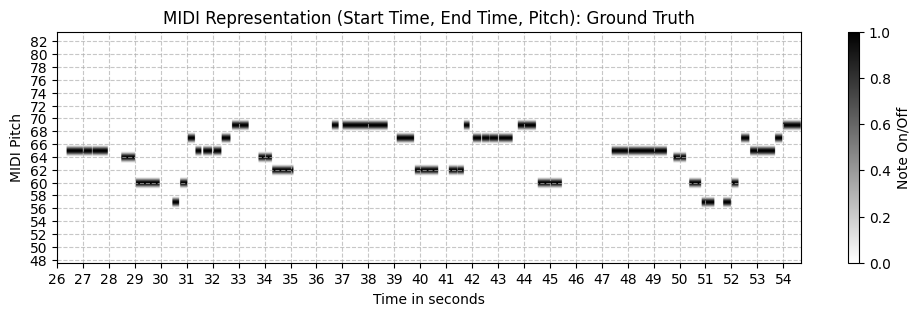

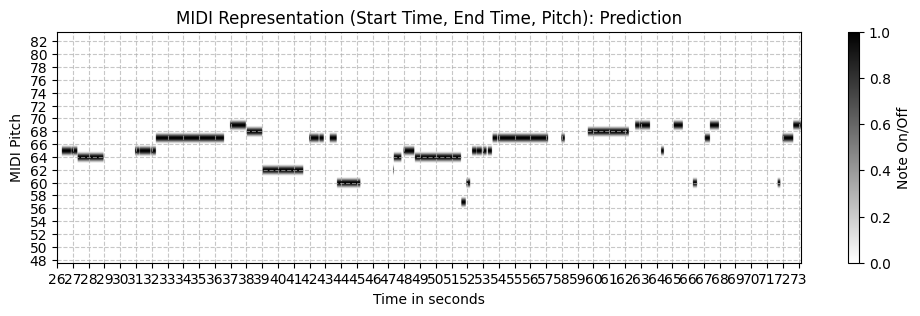

In [119]:
import matplotlib.pyplot as plt
import json
import numpy as np

def visualize(midi_data, annotation_name):
    # Constants for visualization
    num_pitches = 84-48  # MIDI pitches range from 36 to 83
    time_resolution = 0.01  # Time resolution in seconds (adjust as needed)

    # Initialize the piano roll matrix with zeros
    max_end_time = int(max(note[1] for note in midi_data) / time_resolution) + 1
    min_start_time = int(min(note[0] for note in midi_data) / time_resolution) + 1
    num_time_steps = max_end_time - min_start_time
    piano_roll = np.zeros((num_pitches, num_time_steps), dtype=int)

    # Populate the piano roll matrix with note events
    for note in midi_data:
        start_time = int(note[0] / time_resolution)
        end_time = int(note[1] / time_resolution)
        pitch = int(note[2])
        piano_roll[pitch-48, (start_time-min_start_time) : (end_time-min_start_time)] = 1

    # Create a heatmap-like piano roll visualization
    plt.figure(figsize=(12, 3))
    plt.imshow(piano_roll, cmap='binary', aspect='auto', origin='lower')
    plt.xlabel('Time in seconds')
    plt.ylabel('MIDI Pitch')
    plt.title(f'MIDI Representation (Start Time, End Time, Pitch): {annotation_name}')
    plt.colorbar(label='Note On/Off')

    plt.xticks(np.arange(0, num_time_steps, int(1 / time_resolution)), 
               [str(i+(int(min_start_time * time_resolution)+1)) for i in range(0, int(num_time_steps * time_resolution)+1)])
    plt.yticks(np.arange(0, num_pitches, 2), [str(i+48) for i in range(0, num_pitches, 2)])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

ground_truth = json.load(open('data_mini/annotations.json'))
prediction = json.load(open('results/predictions.json'))
print("First 50 secs of Song Number 92")
print("Ground truth length = ", len(ground_truth['92']))
print("Prediction length = ", len(prediction['92']))

visualize(ground_truth['92'][:50], 'Ground Truth')
visualize(prediction['92'][:50], 'Prediction')

[TODO: Please attach your screenshots in this block]

**[Screenshot of finish of training]**

<img src="resources/train1.png" alt="Train1" width="1000" height="600"/>
<img src="resources/train2.png" alt="Train1" width="1000" height="400"/>

**[Screenshot of finish of testing]**

<img src="resources/test.png" alt="Train1"/>

## Section 3 - Questions [13 marks]
**YOUR TASKS:** Please answer the questions below:

1. How does the post-processing algorithm operates? How does it convert frame-level output to note-level output before the final evaluation? Briefly explain your understanding. (You may need to find the corresponding code from some py file and try to understand it before answering.) **[2 marks]**

**Answer:**

1. For every song in the test data, multiple frame-level outputs are collected containing the following info for each frame: `[onset, offset, octave_class, pitch_class]` (`AST_Model.predict()`).

2. These frames are then sent to `AST_Model.parse_frame_info()` to convert frame-level output into note-level predictions for each song.

3. 1 note-level prediction corresponds to `[onset_time, offset_time, pitch from (onset_time, offset_time)]`. 1 song contains multiple note-level predictions. Therefore, we loop through all frames of a song to condense them into multiple notes.

4. Loop through every frame to accumulate notes in a song:
    1. Convert a frame into a time-step.
    2. If the frame is an onset, store the time-step in `current_onset`.
    3. If `current_onset` is set, we look for a frame with an offset. 
        1. While doing so, we maintain a `pitch_counter` to store all the pitches observed between `[current_onset, current_offset]`.
        2. Get the pitch of a frame using the `octave_class` and `pitch_class` of a frame. 
        3. Store the pitch in the `pitch_counter`.
    4. If a frame is an offset, store the time-step in `current_offset`. 
    5. A `note = [current_onset, current_offset, pitch that occured the most no. of times in this duration]`. Add the `note` to results.
    6. Reset `current_onset`, `current_offset`, `pitch_counter` and repeat.

5. Return the set of note-level predictions.

</br>

--------------

2. How did we compute the final note-level performance metrics? Briefly explain how the computation is conducted for a pair of note-level output and annotation for one song. (Hint: look into the code first, and some "useful resources" attached at the beginning of this notebook may help.) **[2 marks]**

**Answer:**

1. For each song, get the following info using the given note-level prediction and ground truth annotation:
    1. `ref_pitches`: MIDI Pitches of all notes in annotation.
    2. `est_pitches`: MIDI Pitches of all notes in prediction.
    3. `ref_intervals`: Time intervals of all notes in annotation (onset and offset times).
    4. `est_intervals`: Time intervals of all notes in prediction (onset and offset times).

2. Convert all MIDI pitch values to hertz.

3. Evaluate the `Precision`, `Recall`, and `F1-score` for 3 categories using the `est` and `ref` info above:
    1. `COnPOff`: Correct onset, pitch, offset.
    2. `COnP`: Correct onset, pitch
    3. `COn`: Correct onset
    
    where the definitions of correct onset, correct pitch, and correct offset are as follows [(ref)](https://riuma.uma.es/xmlui/bitstream/handle/10630/8372/298_Paper.pdf?sequence=1):

    <img src="resources/metrics.png" alt="Train1" width="300" height="300"/>
    
4. Average the metrics over all songs in the test set.

</br>

------------

3. Recall that we are using f1 score in the Metrics class to observe the onset/offset classification performance. Do you think such f1 score is a good performance in this case? What about using accuracy (correct prediction / num of frames) instead, do you think it's proper for onset/offset classification? If not, what are the reasons respectively for the two metrics? What are possible better choices?  **[2 marks]**

**Answer:**

1. Voicing errors can happen when:

    1. an unvoiced sound produces a false transcribed note (spurious note), or 
    2. when a sung note is not transcribed at all (non-detected note).

2. Evaluating onset/offset classification performance using f1 score shows when the machine learning model generates erroneous annotations (precision) and fails to find annotations that it should have found (recall). Therefore, f1 score is a good performance metric in this case as it covers both kinds of voicing errors.

3. Accuracy seems to be a stricter measurement for music transcription, since its possible that the onset and offset values for each note are off by a frame, and hence the accuracy will be very low. However, it can also be used for this classification.

4. We can also use a confusion matrix to evaluate performance.

</br>

-------------

4. How does your system performed? Briefly introduce your system's performance with objective metric scores and your visualization. **[2 marks]**

**Answer:**

My F1-scores are very close to the estimated performance given in Task 7:

    1. `COnPOff`: 14.44%
    2. `COnP`: 36.45%
    3. `COn`: 47.26%

However, the visualization for first 50 notes of song number 92 are not very similar. There is a lot of scope for improvement in the model. Specifically, `COnPOff` is extremely low which can be seen in the visualization, as very few values are the same for all notes. However, the model is able to decently predict just the onset of notes (`COn`).
</br>

-------------

5. The current system might not be performing very well on this dataset, or perform decently but still have room to improve. What are possible reasons for the not-so-good performance, and directions of improvement? Please list 3 pairs of them. **[3 marks]**

**Answer:**

1. Less data: There may not be enough data for the model to learn from. Increasing data would reduce the variance of the model and lead to greater knowledge being learnt.

2. Network architecture: The model overfits on the training data. It can be because the model is too dense to learn all the necessary patterns. We can make the network sparser by dropping a few neurons (dropout layer).

3. Regularization: The objective function can be constrained by adding a regularizer to the loss term. This way we can control the level of overfitting on the training dataset and increase generalization of the model on the test set.

</br>

-------------

6. What do you think is the most difficult part? Which part did you spent most time on it? **[1 mark(s)]**

**Answer:**

The most difficult part was figuring out the shapes (swapping axes, flatenning, normalizing tensor value) of all the tensors in all the methods since there was no standardization anywhere. Also, it was difficult to properly create the melspectogram without knowing what each of its parameters did.
</br>

-----------

7. How much time did you spent on the assignment? Please fill an estimated time here if you did not time yourself. **[1 mark(s)]**

**Answer:**

1.5 week. Including the time taken for all the doubts on canvas to be cleared.
</br>

-------------